In [14]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
 
import warnings
warnings.filterwarnings('ignore')

# File Tools for local
import pandas as pd
import sys

# Random seed for reproducibility
import random

import torch
from botorch.utils.transforms import unnormalize, normalize

from ipywidgets import interact, FloatSlider

#LHS sampling
#from pyDOE import lhs

#from BOClass import Models, Plotting, PoolObjectives
from boclass_gpquery import Models, Plotting, PoolObjectives

from joblib import Parallel, delayed

dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
all_data = pd.read_csv('../all_data.csv') # all_df = pd.concat([data01, data2A, data2B, data2C, data3A, data3B, data3C], axis=0, ignore_index=True)
data01 = all_data[:15]
data2A = all_data[15:30]
data2B = all_data[30:45]
data2C = all_data[45:60]
data3A = all_data[60:75]
data3B = all_data[75:90]
data3C = all_data[90:105]
# Model Sets
set_dataA = pd.concat([data01, data2A, data3A], axis=0, ignore_index=True)
set_dataB = pd.concat([data01, data2B, data3B], axis=0,ignore_index=True)
set_dataC = pd.concat([data01, data2C, data3C], axis=0,ignore_index=True)


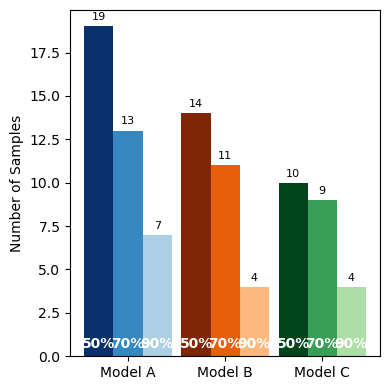

In [16]:
# Check Data
thresholds = [0.5, 0.7, 0.9]

# Calculate counts for each threshold for each model
counts_A = [ (set_dataA['yield product'] > thresh).sum().item() for thresh in thresholds ]
counts_B = [ (set_dataB['yield product'] > thresh).sum().item() for thresh in thresholds ]
counts_C = [ (set_dataC['yield product'] > thresh).sum().item() for thresh in thresholds ]

model_counts = [counts_A, counts_B, counts_C]
model_names = ['ModelA', 'ModelB', 'ModelC']  # Used for cm.*
num_bars_per_model = len(thresholds)

# Bar settings
bar_width = 0.3
x = np.arange(len(model_names))

# Colormap mapping
cmap_dict = {'ModelA': cm.Blues, 'ModelB': cm.Oranges, 'ModelC': cm.Greens}

# Create plot
fig, ax = plt.subplots(figsize=(4, 4))

# Plot each model group
for i, (model, counts) in enumerate(zip(model_names, model_counts)):
    cmap = cmap_dict[model]
    # Light to dark (0 = light, 1 = dark); reversed here for higher threshold to be lighter
    gradient_colors = [cmap(1 - j / num_bars_per_model) for j in range(num_bars_per_model)]
    
    for j, count in enumerate(counts):
        # j = threshold index (0: 0.5, 1: 0.7, 2: 0.9)
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        rect = ax.bar(xpos, count, width=bar_width, color=gradient_colors[j],
                      label=f'{model} - {thresholds[j]:.1f}' if i == 0 else None)  # Only label once per threshold
        ax.bar_label(rect, padding=3, fontsize=8)

# Ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(['Model A', 'Model B', 'Model C'])
ax.set_ylabel('Number of Samples')

# Add annotations for thresholds
for i, model in enumerate(model_names):
    for j, count in enumerate(model_counts[i]):
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        ax.text(xpos, 0.3, f'{thresholds[j]*100:.0f}%', ha='center', va='bottom', fontsize=10, fontweight = 'bold',color='white')

plt.tight_layout()
plt.show()


In [17]:
random_seed = 0
iterations = 3
# Perform a random search on set_dataA for 5 random samples

iteration = np.arange(1, iterations+1)
batch_size = 15

# Iteration 0: Set up gp with initial data
original_bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device)


x_inputs = all_data[['time','temp','sulf','anly'] ]
y_outputs = all_data["yield product"]
yvar_outputs = all_data["var yield"]
# Set the device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
# Convert to torch tensors
x_all = torch.tensor(x_inputs.to_numpy(), dtype=torch.float32)
nx_all = normalize(x_all,original_bounds)
y_all = torch.tensor(y_outputs.values.reshape(-1, 1), dtype=torch.float32)
yvar_all = torch.tensor(yvar_outputs.values.reshape(-1, 1), dtype=torch.float32)

query = PoolObjectives(x_inputs, y_outputs ,yvar_outputs,columns=['time', 'temp', 'sulf', 'anly'],bounds=original_bounds)

plotting = Plotting(query.ground_truth, variable_combinations=('time', 'sulf', 'anly'))
minmax = [y_all.min(), y_all.max()]
plotting.sliced_plotting('ModelA',('time', 'sulf', 'anly'), minmax)

random.seed(5)
random_indices = random.sample(range(x_all.shape[0]), batch_size)
x_train = x_all[random_indices]
nx_train = normalize(x_train, bounds=original_bounds) # normalized data for training

# y_train = y_all[random_indices]
# y_train_var = yvar_all[random_indices]
y_train, y_train_var  = query.query_gp(nx_train)

# Step 1: Initialize your model
gp_model = Models(x_train=nx_train, y_train=y_train, y_train_var=y_train_var, bounds=original_bounds, batch_size=batch_size, objective=query)

# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('time', 'anly', 'sulf'), ('sulf', 'anly', 'time')]
plotting = Plotting(gp_model.model, variable_combinations=variable_combinations)

combination = variable_combinations[0]
minmax = [y_train.min(), y_train.max()]
plotting.sliced_plotting('ModelA',combination, minmax)




In [18]:
def BO_loop_ModelA(gp_model,train_nx, train_y,train_yvar,query,iterations=5):
    for i in range(iterations):
        # Step 3: Get the next candidates
        new_candidates = gp_model.ModelA_candidates(feature='temp').drop(columns=['cluster'])
        x_new = torch.tensor(new_candidates[['time', 'temp', 'sulf', 'anly']].to_numpy(), dtype=dtype, device=device)
        nx_new = normalize(x_new, bounds=original_bounds)
        y_new, yvar_new = query.query_gp(nx_new) # Query from the full dataset

        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_new), dim=0)
        train_y = torch.cat((train_y, y_new), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_new), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=batch_size, objective=query, random_id = random_seed)

    return gp_model, train_nx, train_y, train_yvar


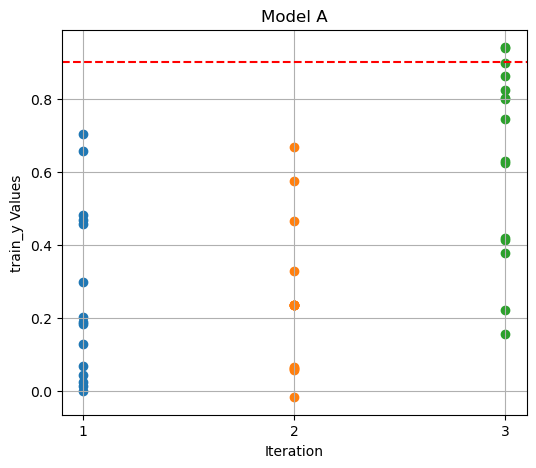

Iteration 1: tensor([163., 145.,  90.,  57.])
Iteration 2: tensor([600.0000, 141.4800,  90.7500, 100.0000])
Iteration 3: tensor([600.0000, 130.9300,  95.1900,  74.9000])


In [19]:
gp_modeA, train_nA, train_yA, train_yvaA = BO_loop_ModelA(gp_model, nx_train, y_train, y_train_var, query,iterations = iterations)

train_xA = unnormalize(train_nA, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_modeA, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelA',combination, minmax)

# Split train_y intoA iterations, each containingA points

points_per_iteration = batch_size
split_data = [train_yA[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]
split_datax = [train_xA[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]

# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('Model A')
plt.xticks(range(1, iterations + 1))
plt.axhline(y=0.9, color='red', linestyle='--', label='y=0.9')
# plt.legend()
plt.grid(True)
plt.show()
argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")

In [20]:
def BO_loop_ModelB(gp_model,train_nx, train_y,train_yvar,query,iterations=5):
    for i in range(iterations):
        # Step 3: Get the next candidates
        new_candidates = gp_model.ModelB_candidates(feature='temp')#.drop(columns=['cluster'])
        x_new = torch.tensor(new_candidates[['time', 'temp', 'sulf', 'anly']].to_numpy(), dtype=dtype, device=device)
        nx_new = normalize(x_new, bounds=original_bounds)
        y_new, yvar_new = query.query_gp(nx_new) # Query from the full dataset

        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_new), dim=0)
        train_y = torch.cat((train_y, y_new), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_new), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=batch_size, objective=query, random_id = random_seed)

    return gp_model, train_nx, train_y, train_yvar


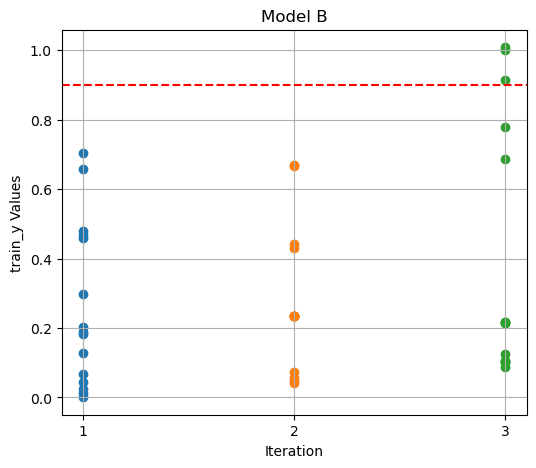

Iteration 1: tensor([163., 145.,  90.,  57.])
Iteration 2: tensor([600.0000, 141.4800,  90.1700,  33.0000])
Iteration 3: tensor([600.0000, 132.4700,  89.4400,  41.3300])


In [21]:
# Reset Pool
x_inputs = all_data[['time','temp','sulf','anly'] ]
y_outputs = all_data["yield product"]
yvar_outputs = all_data["var yield"]

gp_modelB, train_nxB, train_yB, train_yvarB = BO_loop_ModelB(gp_model, nx_train, y_train, y_train_var, query, iterations = iterations)

train_xB = unnormalize(train_nxB, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_modelB, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelB',combination, minmax)


points_per_iteration = batch_size
split_data = [train_yB[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]
split_datax = [train_xB[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]

# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('Model B')
plt.xticks(range(1, iterations + 1))
plt.axhline(y=0.9, color='red', linestyle='--', label='y=0.9')
# plt.legend()
plt.grid(True)
plt.show()
argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")

In [22]:
def BO_loop_ModelC(gp_model,train_nx, train_y,train_yvar,query,iterations=5):
    for i in range(iterations):
        # Step 3: Get the next candidates
        new_candidates = gp_model.ModelC_candidates(feature='temp')
        x_new = torch.tensor(new_candidates[['time', 'temp', 'sulf', 'anly']].to_numpy(), dtype=dtype, device=device)
        nx_new = normalize(x_new, bounds=original_bounds)
        y_new, yvar_new = query.query_gp(nx_new) # Query from the full dataset

        #print(x_train.shape, y_train.shape, yvar_train.shape)
        # Combine the new data with the existing data
        train_nx = torch.cat((train_nx, nx_new), dim=0)
        train_y = torch.cat((train_y, y_new), dim=0)
        train_yvar = torch.cat((train_yvar, yvar_new), dim=0)
        #print(train_nx.shape, train_y.shape, train_yvar.shape)
        # Step 1: Instantiate and train model
        gp_model = Models(x_train=train_nx, y_train=train_y, y_train_var=train_yvar, bounds=original_bounds, batch_size=batch_size, objective=query, random_id = random_seed)

    return gp_model, train_nx, train_y, train_yvar


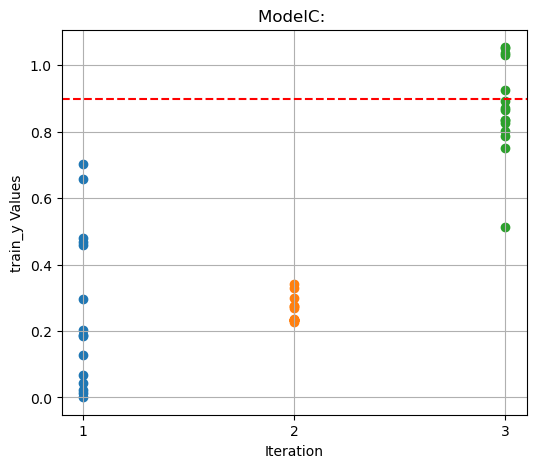

Iteration 1: tensor([163., 145.,  90.,  57.])
Iteration 2: tensor([600.0000, 155.4600,  89.7900,  73.7100])
Iteration 3: tensor([402.7400, 131.6500,  90.4500,  54.3700])


In [23]:
# Reset 
x_inputs = all_data[['time','temp','sulf','anly'] ]
y_outputs = all_data["yield product"]
yvar_outputs = all_data["var yield"]

gp_modelC, train_nxC, train_yC, train_yvarC = BO_loop_ModelC(gp_model, nx_train, y_train, y_train_var, query, iterations = iterations)

train_xC = unnormalize(train_nxC, original_bounds)
# Step 2: Initialize Plotting class
variable_combinations = [('time', 'sulf', 'anly'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(gp_modelC, variable_combinations=variable_combinations)

combination = variable_combinations[0]

minmax = [y_train.min(), y_train.max()]
# plotting.sliced_plotting('ModelC',combination, minmax)


points_per_iteration = batch_size
split_data = [train_yC[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]
split_datax = [train_xC[i * points_per_iteration:(i + 1) * points_per_iteration] for i in range(iterations)]

# Plot the points vertically
plt.figure(figsize=(6, 5))
for i, data in enumerate(split_data):
    plt.scatter([i + 1] * len(data), data.numpy(), label=f'Iteration {i + 1}')

plt.xlabel('Iteration')
plt.ylabel('train_y Values')
plt.title('ModelC: ')
plt.xticks(range(1, iterations + 1))
plt.axhline(y=0.9, color='red', linestyle='--', label='y=0.9')
# plt.legend()
plt.grid(True)
plt.show()

argmax_indices = [data.argmax().item() for data in split_data]
for i, idx in enumerate(argmax_indices):
    print(f"Iteration {i + 1}: {split_datax[i][idx]}")



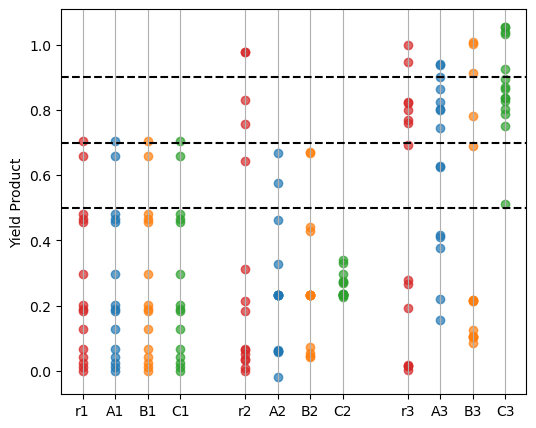

In [24]:
num_samples = batch_size * (iterations-1)
random_samples =  all_data.sample(n=num_samples, random_state=random_seed)
random_sampling = [y_train.numpy().reshape(-1)]+[random_samples.iloc[i*batch_size:(i+1)*batch_size]['yield product'].to_numpy() for i in range(iterations-1)]


offset = 0.2
plt.figure(figsize=(6, 5))
for i, samples in enumerate(random_sampling):
    plt.scatter([iteration[i]] * len(samples), samples, color = 'tab:red' , alpha=0.7)
    # Plot the actual yield product values from set_dataA for each iteration
      # Amount to shift to the right
    plt.scatter([iteration[i] + offset] * batch_size,train_yA[i*batch_size:(i+1)*batch_size].numpy(), 
                color='tab:blue', alpha=0.7, label='set_dataA' if i == 0 else "")
    plt.scatter([iteration[i] + 2*offset] * batch_size, train_yB[i*batch_size:(i+1)*batch_size].numpy(), 
                color='tab:orange', alpha=0.7, label='set_dataB' if i == 0 else "")
    plt.scatter([iteration[i] + 3*offset] * batch_size, train_yC[i*batch_size:(i+1)*batch_size].numpy(), 
                color='tab:green', alpha=0.7, label='set_dataC' if i == 0 else "")
# plt.xlabel('Iteration')
plt.axhline(y=0.9, color='k', linestyle='--', label='y=0.9')
plt.axhline(y=0.7, color='k', linestyle='--', label='y=0.9')
plt.axhline(y=0.5, color='k', linestyle='--', label='y=0.9')
plt.ylabel('Yield Product')
# plt.title('Random Search: Yield Product per Iteration')
plt.grid(axis='x', visible=True)
plt.grid(axis='y', visible=False)
plt.xticks(
    list(iteration) + 
    [i + offset for i in iteration] + 
    [i + 2*offset for i in iteration] + 
    [i + 3*offset for i in iteration],
    [f"r{i}" for i in iteration] + 
    [f"A{i}" for i in iteration] + 
    [f"B{i}" for i in iteration] + 
    [f"C{i}" for i in iteration]
)
plt.show()

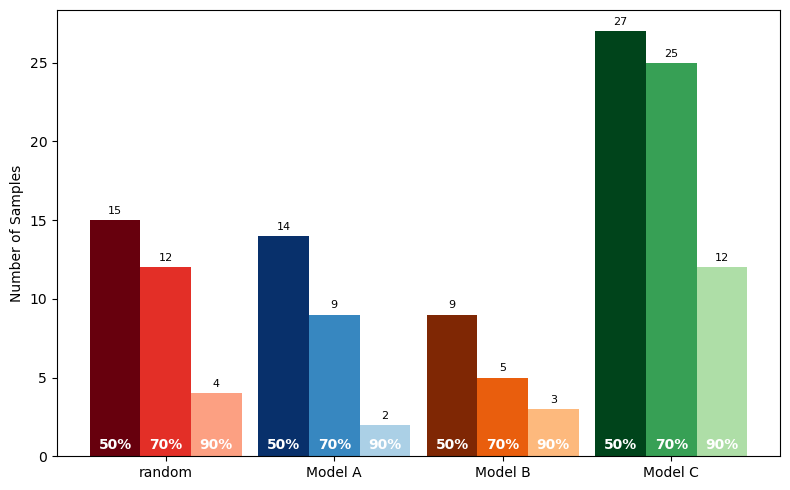

In [25]:
# Check Data
thresholds = [0.5, 0.7, 0.9]

flattened_random_sampling = torch.cat([torch.tensor(samples, dtype=torch.float32) for samples in random_sampling]).reshape(-1, 1)


idsA = [(train_yA > thresh).sum().item() for thresh in thresholds]
idsB = [(train_yB > thresh).sum().item() for thresh in thresholds]
idsC = [(train_yC > thresh).sum().item() for thresh in thresholds]
ids_random = [(flattened_random_sampling > thresh).sum().item() for thresh in thresholds]


model_counts =[ids_random,idsA,idsB,idsC] 
model_names = ['random','ModelA', 'ModelB', 'ModelC']  # Used for cm.*
num_bars_per_model = len(thresholds)

# Bar settings
bar_width = 0.3
x = np.arange(len(model_names))

# Colormap mapping
cmap_dict = {'random':cm.Reds, 'ModelA': cm.Blues, 'ModelB': cm.Oranges, 'ModelC': cm.Greens}

# Create plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot each model group
for i, (model, counts) in enumerate(zip(model_names, model_counts)):
    cmap = cmap_dict[model]
    # Light to dark (0 = light, 1 = dark); reversed here for higher threshold to be lighter
    gradient_colors = [cmap(1 - j / num_bars_per_model) for j in range(num_bars_per_model)]
    
    for j, count in enumerate(counts):
        # j = threshold index (0: 0.5, 1: 0.7, 2: 0.9)
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        rect = ax.bar(xpos, count, width=bar_width, color=gradient_colors[j],
                      label=f'{model} - {thresholds[j]:.1f}' if i == 0 else None)  # Only label once per threshold
        ax.bar_label(rect, padding=3, fontsize=8)

# Ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(['random','Model A', 'Model B', 'Model C'])
ax.set_ylabel('Number of Samples')

# Add annotations for thresholds
for i, model in enumerate(model_names):
    for j, count in enumerate(model_counts[i]):
        xpos = x[i] + j * bar_width - bar_width  # Center group around x[i]
        ax.text(xpos, 0.3, f'{thresholds[j]*100:.0f}%', ha='center', va='bottom', fontsize=10, fontweight = 'bold',color='white')

plt.tight_layout()
plt.show()



- Run Model A, Model B, Model C and random 20 times for 20 differnet seeds. 
- then find the mean and variance of the 20 runs


- The unertainty of the gaussian process regression give us idea about confidence interval. Refer to ESI
- hardware and software

- To future test the robustness of our confidence intervals, the 20 runs figure out the metrics.
eg: # of iterations, How consistently do we get Model A, Model B and Model C the best?

Test 1: sample from the ground truth gaussian
Test 2: sampel form the pool of 105.

In [27]:
def run_single_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)

    # Sample a new initial batch for each run
    random_indices = random.sample(range(x_all.shape[0]), batch_size)
    x_train = x_all[random_indices]
    nx_train = normalize(x_train, bounds=original_bounds)
    y_train = query.query_gp(nx_train)[0]  # Get y values for the initial batch
    y_train_var = query.query_gp(nx_train)[1]  # Get y variance for the initial batch


    # Initialize model
    gp_model = Models(
        x_train=nx_train, y_train=y_train, y_train_var=y_train_var,
        bounds=original_bounds, batch_size=batch_size,
        objective=query, random_id=seed
    )

    # Run BO loop
    gp_modelA, train_nA, train_yA, train_yvaA = BO_loop_ModelA(
        gp_model, nx_train, y_train, y_train_var,
        query, iterations=iterations
    )

    # Count above thresholds
    counts = [(train_yA > thresh).sum().item() for thresh in thresholds]
    return counts

num_runs = 20
results = Parallel(n_jobs=-1)(delayed(run_single_seed)(seed) for seed in range(num_runs))
# Combine into final array/list
modelA_threshold_counts = results



In [29]:
def run_single_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)

    # Sample a new initial batch for each run
    random_indices = random.sample(range(x_all.shape[0]), batch_size)
    x_train = x_all[random_indices]
    nx_train = normalize(x_train, bounds=original_bounds)
    y_train = query.query_gp(nx_train)[0]  # Get y values for the initial batch
    y_train_var = query.query_gp(nx_train)[1]  # Get y variance for the initial batch

    # Initialize model
    gp_model = Models(
        x_train=nx_train, y_train=y_train, y_train_var=y_train_var,
        bounds=original_bounds, batch_size=batch_size,
        objective=query, random_id=seed
    )

    # Run BO loop
    gp_modelB, train_nB, train_yB, train_yvaB = BO_loop_ModelB(
        gp_model, nx_train, y_train, y_train_var,
        query, iterations=iterations
    )

    # Count above thresholds
    counts = [(train_yB > thresh).sum().item() for thresh in thresholds]
    return counts

num_runs = 20
results = Parallel(n_jobs=-1)(delayed(run_single_seed)(seed) for seed in range(num_runs))
# Combine into final array/list
modelB_threshold_counts = results


In [30]:
def run_single_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)

    # Sample a new initial batch for each run
    random_indices = random.sample(range(x_all.shape[0]), batch_size)
    x_train = x_all[random_indices]
    nx_train = normalize(x_train, bounds=original_bounds)
    y_train = query.query_gp(nx_train)[0]  # Get y values for the initial batch
    y_train_var = query.query_gp(nx_train)[1]  # Get y variance for the initial batch

    # Initialize model
    gp_model = Models(
        x_train=nx_train, y_train=y_train, y_train_var=y_train_var,
        bounds=original_bounds, batch_size=batch_size,
        objective=query, random_id=seed
    )

    # Run BO loop
    gp_modelC, train_nC, train_yC, train_yvaC = BO_loop_ModelC(
        gp_model, nx_train, y_train, y_train_var,
        query, iterations=iterations
    )

    # Count above thresholds
    counts = [(train_yC > thresh).sum().item() for thresh in thresholds]
    return counts

num_runs = 20
results = Parallel(n_jobs=-1)(delayed(run_single_seed)(seed) for seed in range(num_runs))
# Combine into final array/list
modelC_threshold_counts = results


In [31]:
# Run random sampling 20 times with different seeds and store threshold counts
# Q: run the random sampling 20 times with a differnt seed and store the threshold counts
num_runs = 20
random_threshold_counts = []

for seed in range(num_runs):
    random_samples = all_data.sample(n=num_samples, random_state=seed)
    y_train_df = pd.DataFrame(y_train.numpy(), columns=['yield product'])
    random_sampling = [y_train_df] + [random_samples.iloc[i*batch_size:(i+1)*batch_size]['yield product'] for i in range(iterations-1)]
    flattened = pd.concat(random_sampling).values.flatten().reshape(-1, 1)
    counts = [(flattened > thresh).sum() for thresh in thresholds]
    random_threshold_counts.append(counts)



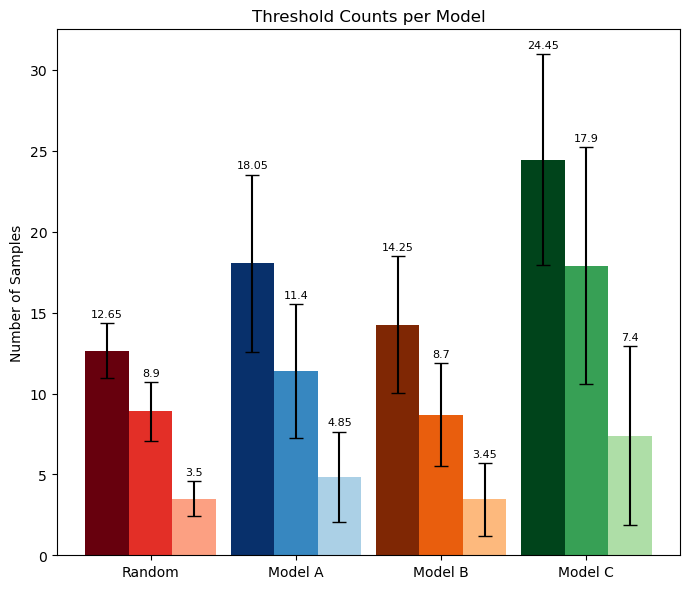

In [38]:
# Assuming thresholds is defined somewhere, e.g.:
# thresholds = [0.5, 0.7, 0.9]

# Convert results to numpy arrays if not already
modelA_threshold_counts = np.array(modelA_threshold_counts)
modelB_threshold_counts = np.array(modelB_threshold_counts)
modelC_threshold_counts = np.array(modelC_threshold_counts)
random_threshold_counts = np.array(random_threshold_counts)

# Compute mean and std for each threshold
mean_counts = [
    random_threshold_counts.mean(axis=0),
    modelA_threshold_counts.mean(axis=0),
    modelB_threshold_counts.mean(axis=0),
    modelC_threshold_counts.mean(axis=0),
]
std_counts = [
    random_threshold_counts.std(axis=0),
    modelA_threshold_counts.std(axis=0),
    modelB_threshold_counts.std(axis=0),
    modelC_threshold_counts.std(axis=0),
]

model_names = ['random', 'ModelA', 'ModelB', 'ModelC']
num_models = len(model_names)
num_thresholds = len(thresholds)

# Bar settings
bar_width = 0.3
x = np.arange(num_models)

# Colormap mapping
cmap_dict = {'random': cm.Reds, 'ModelA': cm.Blues, 'ModelB': cm.Oranges, 'ModelC': cm.Greens}

# Create plot
fig, ax = plt.subplots(figsize=(7, 6))

# Plot each threshold group across all models
for j, threshold in enumerate(thresholds):
    # For each threshold, collect the counts and stds from all models
    counts = [mean_counts[i][j] for i in range(num_models)]
    stds = [std_counts[i][j] for i in range(num_models)]
    cmap_colors = [cmap_dict[model_names[i]](1 - j / num_thresholds) for i in range(num_models)]
    xpos = x + (j - 1) * bar_width  # Shift bars left/right around center

    rects = ax.bar(xpos, counts, width=bar_width, color=cmap_colors, yerr=stds, capsize=5, label=f'Threshold {threshold:.1f}')
    ax.bar_label(rects, padding=3, fontsize=8)

# Ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(['Random', 'Model A', 'Model B', 'Model C'])
ax.set_ylabel('Number of Samples')
ax.set_title('Threshold Counts per Model')

# Legend
# ax.legend(title='Threshold')

plt.tight_layout()
plt.show()

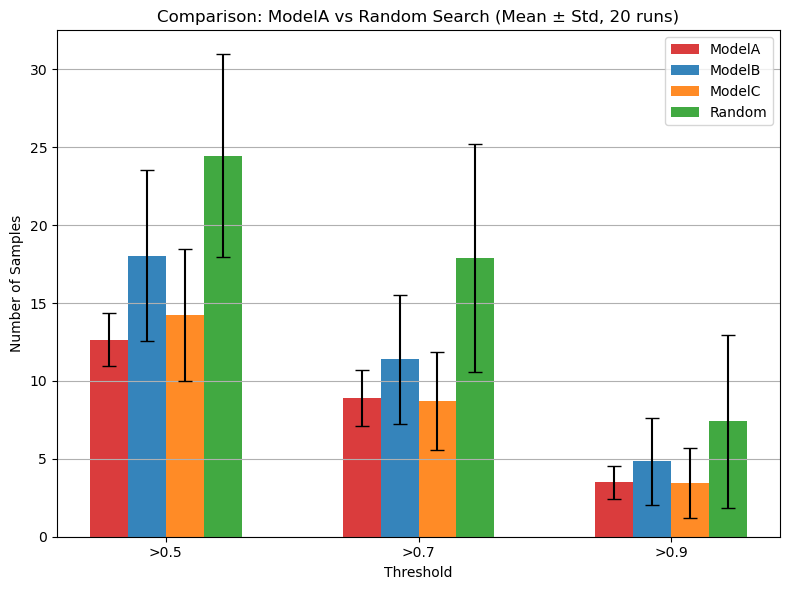

In [34]:
modelA_threshold_counts = np.array(modelA_threshold_counts)
mean_countsA = modelA_threshold_counts.mean(axis=0)
var_countsA = modelA_threshold_counts.var(axis=0)

modelB_threshold_counts = np.array(modelB_threshold_counts)
mean_countsB = modelB_threshold_counts.mean(axis=0)
var_countsB = modelB_threshold_counts.var(axis=0)

modelC_threshold_counts = np.array(modelC_threshold_counts)
mean_countsC = modelC_threshold_counts.mean(axis=0)
var_countsC = modelC_threshold_counts.var(axis=0)

random_threshold_counts = np.array(random_threshold_counts)
#print(random_threshold_counts)
# Compute mean and variance across runs for each threshold
mean_countsR = random_threshold_counts.mean(axis=0)
var_countsR = random_threshold_counts.var(axis=0)

# Plot ModelA vs Random Search mean and variance for each threshold
plt.figure(figsize=(8, 6))
bar_width = 0.15
indices = np.arange(len(thresholds))

# Plot ModelA vs Random Search mean and variance for each threshold
plt.bar(indices - bar_width*1.5, mean_countsR, bar_width, yerr=np.sqrt(var_countsR), capsize=5, label='ModelA', color='tab:red', alpha=0.9)
plt.bar(indices - bar_width/2, mean_countsA, bar_width, yerr=np.sqrt(var_countsA), capsize=5, label='ModelB', color='tab:blue', alpha=0.9)
plt.bar(indices + bar_width/2, mean_countsB, bar_width, yerr=np.sqrt(var_countsB), capsize=5, label='ModelC', color='tab:orange', alpha=0.9)
plt.bar(indices + bar_width*1.5, mean_countsC, bar_width, yerr=np.sqrt(var_countsC), capsize=5, label='Random', color='tab:green', alpha=0.9)

plt.xticks(indices, [f'>{t}' for t in thresholds])
plt.ylabel('Number of Samples')
plt.xlabel('Threshold')
plt.title('Comparison: ModelA vs Random Search (Mean ± Std, 20 runs)')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()